In [1]:
!nvidia-smi

Sun Feb 26 22:22:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1D:00.0 Off |                    0 |
| N/A   32C    P0    42W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
import torch
print(torch.__version__)
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

/home/avshmelev/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu117


In [3]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

In [4]:
from numba import njit, prange
import time
import seaborn as sns

In [5]:
def get_train_test_nodes(df, train_coeff, NC=False):
    
    # get list of all labels
    types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
    print("TYPES: ", types)
    
    # concatenate all nodes in one column
    n = pd.concat([df['node_id1'], df['node_id2']], axis=0)
    
    # concatenate all labels in one column
    l = pd.concat([df['label_id1'], df['label_id2']], axis=0)
    
    # merge all nodes and all labels column-wise
    df_new = pd.concat([n, l], axis=1)
    
    # get class for every node 
    df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_new.iloc[:, 1] = df_new.iloc[:, 1].apply(lambda t: types.index(t))
    df_new = df_new.drop_duplicates()
    node_classes_random = df_new.sample(frac=1)
    node_classes_sorted = df_new.sort_values(by=[0])
    
    if NC:
        missed_nodes = []
        for i in range(node_classes_sorted.shape[0]):
            if i not in node_classes_sorted.iloc[:, 0].to_numpy():
                missed_nodes.append([i, -1])
        
        tmp_df = pd.DataFrame(missed_nodes)
        
        print(tmp_df)
        
        node_classes_sorted = pd.concat([node_classes_sorted, tmp_df], axis=0).sort_values(by=[0])
    
    # get number of nodes for every class
    num_nodes_per_class = node_classes_random.iloc[:, 1].value_counts()
    
    train_nodes, test_nodes = [], []
    node_counter = {i:0 for i in range(num_nodes_per_class.shape[0])}
    
    # split nodes
    for i in range(node_classes_random.shape[0]):
        node_class = node_classes_random.iloc[i, 1]
        if node_counter[node_class] < int(train_coeff * num_nodes_per_class.loc[node_class]):
            train_nodes.append(node_classes_random.iloc[i, 0])
            node_counter[node_class] += 1
        else:
            test_nodes.append(node_classes_random.iloc[i, 0])
    
    return train_nodes, test_nodes, node_classes_sorted

def make_train_test_dataset(df, train_nodes: list, test_nodes: list, node_classes_sorted):
    
    # get list of all labels
    types = pd.concat([df['label_id1'], df['label_id2']], axis=0).unique().tolist()
    print("TYPES: ", types)
    
    # preprocess initial data
    df_processed = df.copy()
    df_processed.iloc[:, 0] = df_processed.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
    df_processed.iloc[:, 1] = df_processed.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))
    df_processed.iloc[:, 2] = df_processed.iloc[:, 2].apply(lambda t: types.index(t))
    df_processed.iloc[:, 3] = df_processed.iloc[:, 3].apply(lambda t: types.index(t))
    
    # making dataframe with only training nodes
    df_for_training = df_processed.copy()
    
    drop_rows = drop_rows_for_training_dataset(df_for_training.to_numpy(), np.array(test_nodes))
    
    df_for_training = df_for_training.drop(drop_rows)
    
    # construct training graph ############################# SAME PART BELOW ##############################
    
    # construct hash map for training nodes
    hashmap = np.array([1e6 for i in range(len(train_nodes + test_nodes))]).astype(int)
    for i, node in enumerate(train_nodes):
        hashmap[node] = i
        
    print(hashmap)
    
    # calculate sum of idb for each training node
    sum_training_idb = np.zeros((len(train_nodes), len(types)))
    
    calculate_sum_of_idb_for_each_node(sum_training_idb, df_for_training.to_numpy(), hashmap)
        
    print(node_classes_sorted)
                
    # construct targets
    targets = construct_node_classes(node_classes_sorted.to_numpy(), train_nodes)
        
    # construct edges
    train_graph_weighted_edges = construct_edges(df_for_training.to_numpy(), hashmap)
    
    sort_idx = np.argsort(train_graph_weighted_edges[:, 0])
    train_graph_weighted_edges = train_graph_weighted_edges[sort_idx]
    
    train_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_training_idb), 'weight': torch.tensor(train_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(train_graph_weighted_edges[:, :2].T, dtype=torch.long)})
    
    train_graph_pytorch.num_classes = len(types)
    
    ############################# SAME PART UP ##############################
    
    # creating array of graphs for testing
    
    array_of_graphs_for_testing = []
    
    print('Starting selecting lines...')
    
    start = time.time()
    
    rows_for_adding_per_node = select_lines(np.array(train_nodes), np.array(test_nodes), df_processed.to_numpy())
    
    end = time.time()
    
    print(f'Done selecting lines in {end-start} seconds')
    
    for k, test_node in enumerate(test_nodes):
        
        print(f'Processed {k} / {len(test_nodes)} nodes')
        
        rows_for_adding = rows_for_adding_per_node[k]
                
        df_for_testing = pd.concat([df_for_training, df_processed.iloc[rows_for_adding]], axis=0)
        
        current_test_nodes = train_nodes + [test_node]
        
        # construct testing graph ############################# SAME PART BELOW ##############################
    
        start = time.time()
        
        # construct hash map for training nodes
        hashmap = np.array([1e6 for i in range(len(train_nodes + test_nodes))]).astype(int)
        for i, node in enumerate(current_test_nodes):
            hashmap[node] = i
    
        # calculate sum of idb for each training node
        sum_testing_idb = np.zeros((len(current_test_nodes), len(types)))
    
        calculate_sum_of_idb_for_each_node(sum_testing_idb, df_for_testing.to_numpy(), hashmap)
            
        print(f'calculate sum of idb for each training node: {time.time() - start}')
        
        start = time.time()

        # construct targets
        targets = construct_node_classes(node_classes_sorted.to_numpy(), current_test_nodes)
            
        print(f'construct targets: {time.time() - start}')
        
        start = time.time()

        # construct edges
        test_graph_weighted_edges = construct_edges(df_for_testing.to_numpy(), hashmap)
        
        sort_idx = np.argsort(test_graph_weighted_edges[:, 0])
        test_graph_weighted_edges = test_graph_weighted_edges[sort_idx]
            
        print(f'construct edges: {time.time() - start}')
        
#         start = time.time()

        test_graph_pytorch = Data.from_dict({'y': torch.tensor(targets, dtype=torch.long), 'x': torch.tensor(sum_testing_idb), 'weight': torch.tensor(test_graph_weighted_edges[:, 2]), 'edge_index': torch.tensor(test_graph_weighted_edges[:, :2].T, dtype=torch.long)})
        
        test_graph_pytorch.num_classes = len(types)
        
        array_of_graphs_for_testing.append(test_graph_pytorch)
        
#         print(f'build pytorch geometric dataset: {time.time() - start}')
        
        ############################# SAME PART UP ##############################
    
    return train_graph_pytorch, array_of_graphs_for_testing, types

In [6]:
@njit(cache=True)
def select_lines(train_nodes, test_nodes, df_processed):
    
    rows_for_adding_per_node = []
    
    for i in range(len(test_nodes)):
        tmp = []
        for j in range(df_processed.shape[0]):
            row = df_processed[j]
            if int(row[0]) == test_nodes[i] and int(row[1]) in train_nodes or int(row[1]) == test_nodes[i] and int(row[0]) in train_nodes:
                
                tmp.append(j)
                
        rows_for_adding_per_node.append(tmp)
    
    return rows_for_adding_per_node


@njit(cache=True)
def calculate_sum_of_idb_for_each_node(sum_testing_ibd, df_for_testing, hashmap):
    
    for i in range(df_for_testing.shape[0]):
        row = df_for_testing[i]
        sum_testing_ibd[hashmap[int(row[0])], int(row[3])] += row[4]
        sum_testing_ibd[hashmap[int(row[1])], int(row[2])] += row[4]


@njit(cache=True)
def construct_edges(df_for_testing, hashmap):
    
    test_graph_weighted_edges = []
    
    for i in range(df_for_testing.shape[0]):
        row = df_for_testing[i]
        test_graph_weighted_edges.append([hashmap[int(row[0])], hashmap[int(row[1])], row[4]])
        test_graph_weighted_edges.append([hashmap[int(row[1])], hashmap[int(row[0])], row[4]])
        
    return np.array(test_graph_weighted_edges)


@njit(cache=True)
def drop_rows_for_training_dataset(df_for_training, test_nodes):
    drop_rows = []
    for i in range(df_for_training.shape[0]): # speed it up in future
        if i % 1000 == 0:
            print(f'Processed {i} / {df_for_training.shape[0]} lines for training dataset')
        row = df_for_training[i, :]
        if int(row[0]) in test_nodes or int(row[1]) in test_nodes:
            drop_rows.append(i)
            
    return drop_rows


@njit(cache=True)
def construct_node_classes(node_classes_sorted, current_nodes):
    targets = []
    for node in current_nodes:
        targets.append(node_classes_sorted[node, 1])
        
    return targets

In [7]:
def parse_metis_file_to_dataframe(path):
    
    data = []
    types = ['Central-Russia', 'Jews']
    
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if i % 10000 == 0:
                print(f"Done {i} / lines")
            tmp = []
            if i != 0:
                items = line.split(',')
                
                node1 = items[0]
                node2 = items[1]
                ibd = float(items[2])
                
                if items[3][0] == "\"":
                    node1_p1 = items[3].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    node1_p2 = items[4].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    
                    if float(node1_p1[1]) > float(node1_p2[1]): #50% / 50% ???
                        node1_type = types.index(node1_p1[0])
                    else:
                        node1_type = types.index(node1_p2[0])
                        
                    if items[5][0] == "\"":
                        node2_p1 = items[5].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                        node2_p2 = items[6].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")

                        if float(node2_p1[1]) > float(node2_p2[1]): #50% / 50% ???
                            node2_type = types.index(node2_p1[0])
                        else:
                            node2_type = types.index(node2_p2[0])
                            
                    else:
                        node2_p1 = items[5].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    
                        node2_type = types.index(node2_p1[0])
                    
                else:
                    node1_p1 = items[3].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                    
                    node1_type = types.index(node1_p1[0])
                    
                    if items[4][0] == "\"":
                        node2_p1 = items[4].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")
                        node2_p2 = items[5].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').replace(" ", '').split(":")

                        if float(node2_p1[1]) > float(node2_p2[1]): #50% / 50% ???
                            node2_type = types.index(node2_p1[0])
                        else:
                            node2_type = types.index(node2_p2[0])
                            
                    else:
                        node2_p1 = items[4].replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace("'", '').replace("\"", '').split(":")
                    
                        node2_type = types.index(node2_p1[0])
                    
                    
                tmp = [node1, node2, node1_type, node2_type, ibd]
                data.append(tmp)
    
    return pd.DataFrame(data, columns=['node_id1', 'node_id2', 'label_id1', 'label_id2', 'ibd_sum'])

In [8]:
metis_df = parse_metis_file_to_dataframe('CR_Jews_graph_weights_labels.csv')

Done 0 / lines
Done 10000 / lines
Done 20000 / lines
Done 30000 / lines
Done 40000 / lines
Done 50000 / lines
Done 60000 / lines
Done 70000 / lines
Done 80000 / lines
Done 90000 / lines
Done 100000 / lines
Done 110000 / lines
Done 120000 / lines
Done 130000 / lines
Done 140000 / lines
Done 150000 / lines
Done 160000 / lines
Done 170000 / lines
Done 180000 / lines
Done 190000 / lines
Done 200000 / lines
Done 210000 / lines
Done 220000 / lines
Done 230000 / lines
Done 240000 / lines
Done 250000 / lines
Done 260000 / lines
Done 270000 / lines
Done 280000 / lines
Done 290000 / lines
Done 300000 / lines
Done 310000 / lines
Done 320000 / lines
Done 330000 / lines
Done 340000 / lines
Done 350000 / lines
Done 360000 / lines
Done 370000 / lines
Done 380000 / lines
Done 390000 / lines
Done 400000 / lines
Done 410000 / lines
Done 420000 / lines
Done 430000 / lines
Done 440000 / lines
Done 450000 / lines
Done 460000 / lines
Done 470000 / lines
Done 480000 / lines
Done 490000 / lines
Done 500000 / 

In [9]:
metis_df

,node_id1,node_id2,label_id1,label_id2,ibd_sum
0,node_0,node_119,0,0,12.45480
1,node_0,node_284,0,0,9.51299
2,node_0,node_291,0,0,9.05144
3,node_0,node_306,0,0,16.99570
4,node_0,node_813,0,0,10.10270
...,...,...,...,...,...
1250451,node_10962,node_10984,1,1,25.42430
1250452,node_10963,node_10976,0,1,12.79950
1250453,node_10969,node_10985,0,0,9.86943
1250454,node_10983,node_10985,1,0,8.44684


In [10]:
tr, ts, nks = get_train_test_nodes(metis_df, 0.7, NC=False) # to-do: 70:30 split ration because kenenbek did it this way
data, test_graphs, types = make_train_test_dataset(metis_df, tr, ts, nks)

TYPES:  [0, 1]


/tmp/job-1072675/ipykernel_162117/3598466770.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_new.iloc[:, 0] = df_new.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))


TYPES:  [0, 1]


/tmp/job-1072675/ipykernel_162117/3598466770.py:60: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_processed.iloc[:, 0] = df_processed.iloc[:, 0].apply(lambda n: int(n.split('_')[1]))
/tmp/job-1072675/ipykernel_162117/3598466770.py:61: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_processed.iloc[:, 1] = df_processed.iloc[:, 1].apply(lambda n: int(n.split('_')[1]))


Processed 0 / 1250456 lines for training dataset
Processed 1000 / 1250456 lines for training dataset
Processed 2000 / 1250456 lines for training dataset
Processed 3000 / 1250456 lines for training dataset
Processed 4000 / 1250456 lines for training dataset
Processed 5000 / 1250456 lines for training dataset
Processed 6000 / 1250456 lines for training dataset
Processed 7000 / 1250456 lines for training dataset
Processed 8000 / 1250456 lines for training dataset
Processed 9000 / 1250456 lines for training dataset
Processed 10000 / 1250456 lines for training dataset
Processed 11000 / 1250456 lines for training dataset
Processed 12000 / 1250456 lines for training dataset
Processed 13000 / 1250456 lines for training dataset
Processed 14000 / 1250456 lines for training dataset
Processed 15000 / 1250456 lines for training dataset
Processed 16000 / 1250456 lines for training dataset
Processed 17000 / 1250456 lines for training dataset
Processed 18000 / 1250456 lines for training dataset
Proces

Step 0


/home/avshmelev/.conda/envs/genotek/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/avshmelev/.conda/envs/genotek/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/avshmelev/.conda/envs/genotek/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2626
           1       0.00      0.00      0.00       672

    accuracy                           0.80      3298
   macro avg       0.40      0.50      0.44      3298
weighted avg       0.63      0.80      0.71      3298



<Figure size 640x480 with 0 Axes>

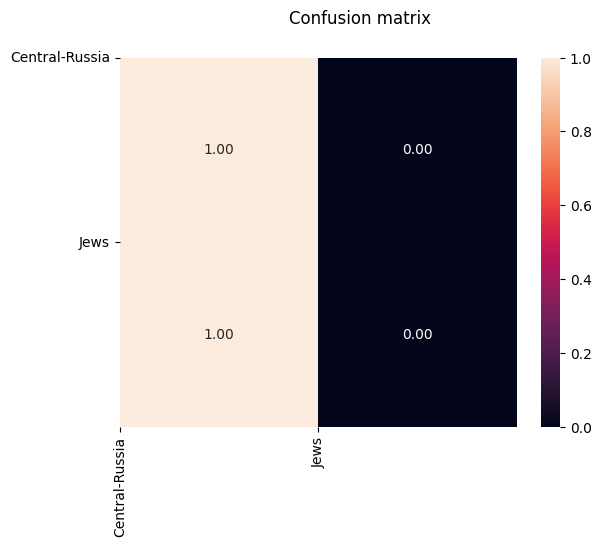

F1 score weighted: 0.7059171580672754
Step 1000
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2626
           1       0.86      0.94      0.90       672

    accuracy                           0.96      3298
   macro avg       0.92      0.95      0.94      3298
weighted avg       0.96      0.96      0.96      3298



<Figure size 640x480 with 0 Axes>

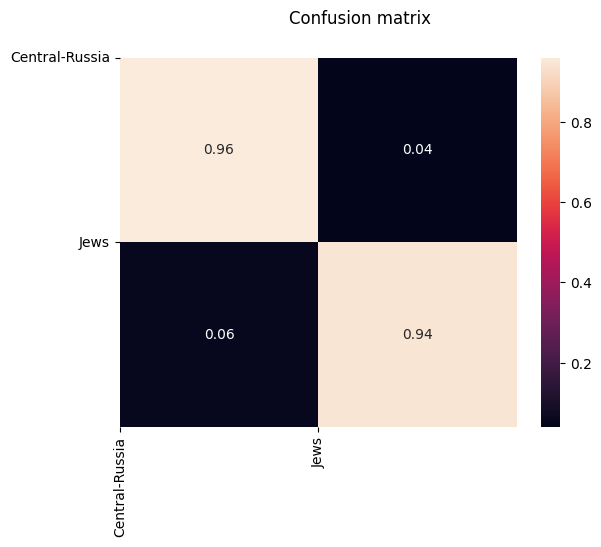

F1 score weighted: 0.9582529675427265
Step 2000
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2626
           1       0.93      0.89      0.91       672

    accuracy                           0.96      3298
   macro avg       0.95      0.94      0.94      3298
weighted avg       0.96      0.96      0.96      3298



<Figure size 640x480 with 0 Axes>

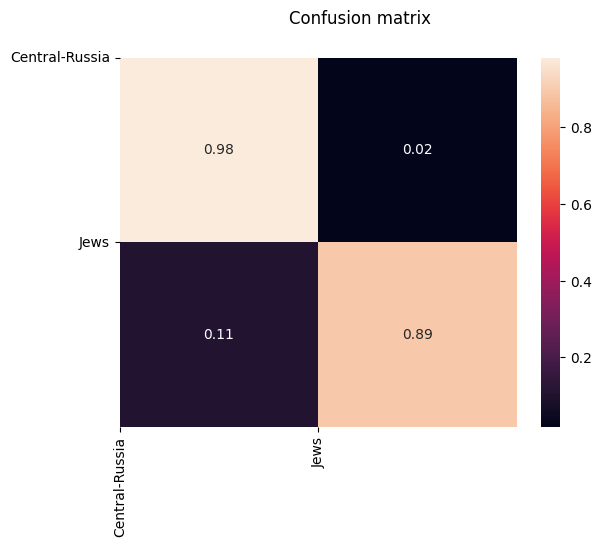

F1 score weighted: 0.9642717864052223
Step 3000
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2626
           1       0.92      0.93      0.92       672

    accuracy                           0.97      3298
   macro avg       0.95      0.95      0.95      3298
weighted avg       0.97      0.97      0.97      3298



<Figure size 640x480 with 0 Axes>

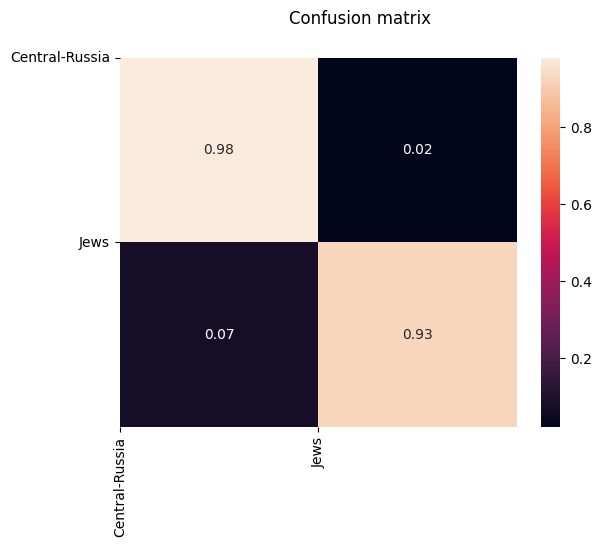

F1 score weighted: 0.968794804473593
Step 4000
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2626
           1       0.96      0.88      0.92       672

    accuracy                           0.97      3298
   macro avg       0.97      0.94      0.95      3298
weighted avg       0.97      0.97      0.97      3298



<Figure size 640x480 with 0 Axes>

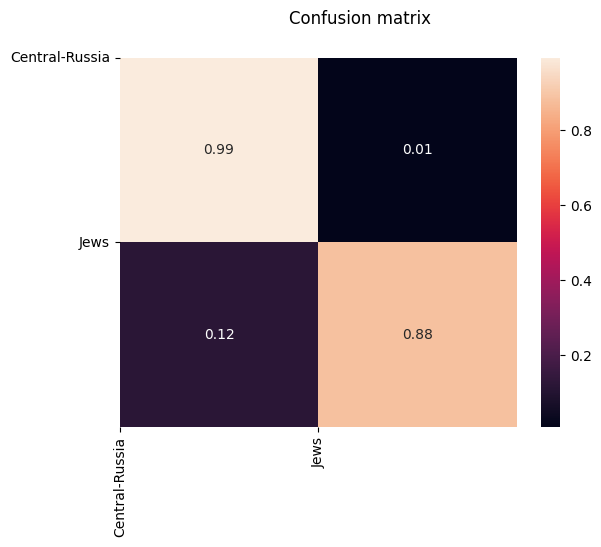

F1 score weighted: 0.9685436345136136
Step 5000


In [ ]:
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, NNConv, SGConv, ARMAConv, TAGConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = TAGConv(data.num_features, 128)
        self.conv2 = TAGConv(128, 128)
        self.conv3 = TAGConv(128, int(data.num_classes))

    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.weight.float()
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define optimizer.

def evaluation(model, test_graphs, step):
    model.eval()
    y_true = []
    y_pred = []

    for i in range(len(test_graphs)):
        y_pred.append(np.argmax(F.softmax(model(test_graphs[i].to(device))[-1], dim=0).cpu().detach().numpy()))
        y_true.append(test_graphs[i].y[-1].cpu().detach())
        test_graphs[i].cpu()
    
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    sns.heatmap(cm, annot=True, fmt=".2f", ax=ax)
    ax.set_xticks([i for i in range(len(types))])
    ax.set_xticklabels(['Central-Russia', 'Jews'])
    ax.set_yticks([i for i in range(len(types))])
    ax.set_yticklabels(['Central-Russia', 'Jews'])
    fig.suptitle("Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90) 
    plt.savefig(rf"cm_cr_{step}.png", bbox_inches="tight")
    plt.show()
    
    print(f"F1 score weighted: {f1_score(y_true, y_pred, average='weighted')}")
    model.train()
    

def train(data, log_step, num_epochs, test_graphs):
    model.train()
    data = data.to(device)
    for i in range(num_epochs):
        if i % log_step == 0:
            print(f'Step {i}')
            evaluation(model, test_graphs, i)
        optimizer.zero_grad()  # Clear gradients.
        out= model(data)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

train(data, 1000, 30000, test_graphs)

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

In [29]:
data = data.to('cpu')

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

for i in range(len(test_graphs)):
    test_graphs[i].cpu()